# Lorenz System with NeuroDiffEq

Uses NeuroDiffEq to propagate the Lorenz System.

In [93]:
!pip install neurodiffeq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [94]:
from neurodiffeq import diff
from neurodiffeq.solvers import Solver1D
from neurodiffeq.monitors import Monitor1D
from neurodiffeq.conditions import IVP
from neurodiffeq.networks import FCNN, SinActv

In [95]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import integrate

In [4]:
# chaos
sigma = 10.
rho = 28.
beta = 8./3.

In [41]:
# transient to chaos
sigma = 10.
rho = 20
beta = 8./3.

In [54]:
# transient to chaos
sigma = 10.
rho = 15.
beta = 8./3.

In [73]:
# global stable
sigma = 10.
rho = 0.6
beta = 8./3.

In [83]:
# bifurcation
sigma = 10.
rho = 1.0
beta = 8./3.

In [96]:
# intermittency
sigma = 10.
rho = 35.
beta = 8./3.

In [55]:
def lorenz_system(x,y,z,t):
    return [
        diff(x,t) - sigma*(y - x),
        diff(y,t) - x*(rho - z) + y,
        diff(z,t) - x*y + beta*z
    ]

In [56]:
#Y_init = [7, 7, 5]
Y_init = [-8, 7, 27]
t_range = (0.,20.)

In [57]:
conditions = [
    IVP(t_0=0.0, u_0=Y_init[0]),
    IVP(t_0=0.0, u_0=Y_init[1]),
    IVP(t_0=0.0, u_0=Y_init[2])
]
nets = [
    FCNN(hidden_units=(32,32), actv=SinActv),
    FCNN(hidden_units=(32,32), actv=SinActv),
    FCNN(hidden_units=(32,32), actv=SinActv)
]
#nets = [
#    FCNN(hidden_units=(64,64), actv=SinActv),
#    FCNN(hidden_units=(64,64), actv=SinActv),
#    FCNN(hidden_units=(64,64), actv=SinActv)
#]

/usr/local/lib/python3.7/dist-packages/neurodiffeq/monitors.py:48: UserWarning: You seem to be using jupyter notebook with '%matplotlib inline' which can lead to monitor plots not updating. Consider using '%matplotlib notebook' or '%matplotlib widget' instead.
  UserWarning)


Training Progress:   0%|          | 0/20000 [00:00<?, ?it/s]

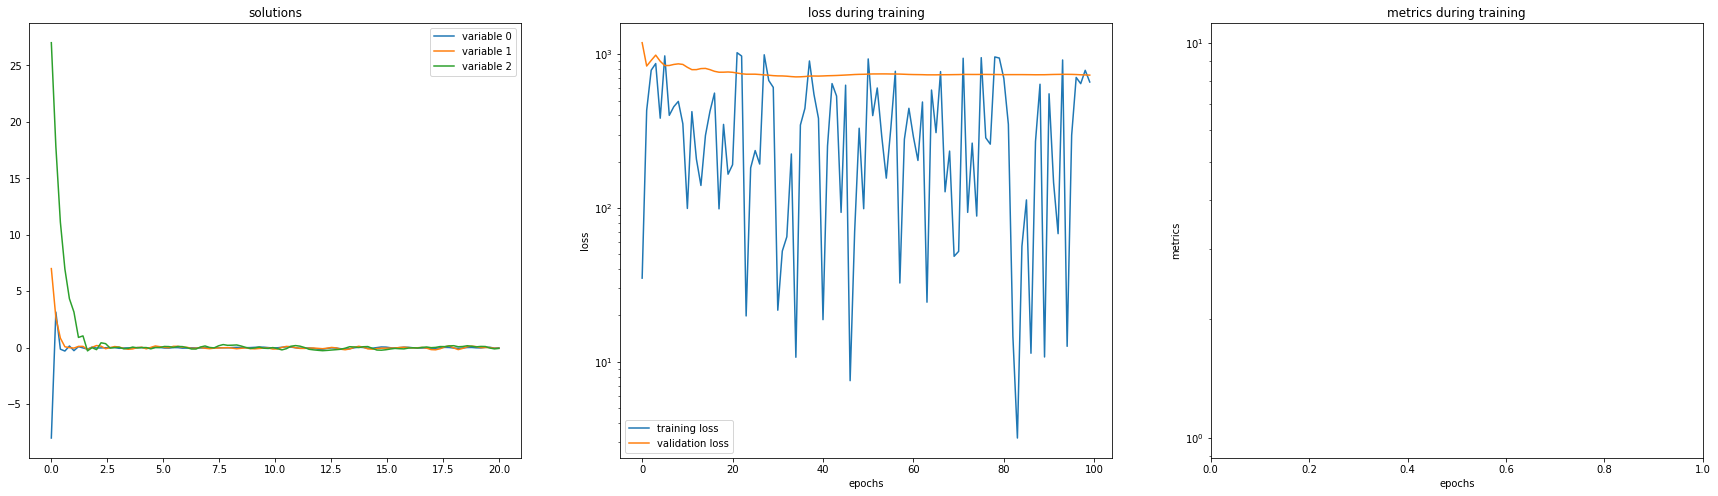

In [97]:
monitor = Monitor1D(t_min=t_range[0], t_max=t_range[1], check_every=100)
monitor_callback = monitor.to_callback()
solver = Solver1D(
    ode_system=lorenz_system,
    conditions=conditions, t_min=t_range[0], t_max=t_range[1],
    nets=nets
)

solver.fit(max_epochs=20000, callbacks=[monitor_callback])
solution = solver.get_solution()

In [98]:
solution = solver.get_solution()

In [60]:
from scipy import integrate
import numpy as np

def lorenzeq(t, Y):
    x, y, z = Y
    dxdt = sigma*(y - x)
    dydt = x*(rho - z) - y
    dzdt = x*y - beta*z
    return dxdt, dydt, dzdt

def lorenzeq1(Y, t):
    x, y, z = Y
    dxdt = sigma*(y - x)
    dydt = x*(rho - z) - y
    dzdt = x*y - beta*z
    return [dxdt, dydt, dzdt]

def lorenzeq_jac(t, Y):
    x, y, z = Y
    J = np.array(
        [[-sigma,sigma,0],
        [rho - z, -1, -x],
        [y,x,-beta]]
    )
    return J

def integrate_forward(func,t_range,Y_init,N,J):
    t = np.linspace(t_range[0], t_range[1], N)

    sol = integrate.solve_ivp(func, t_range, Y_init, method='LSODA',t_eval=t, jac=J)
    x,y,z = sol.y
    x = x.reshape(N, 1).flatten()
    y = y.reshape(N, 1).flatten()
    z = z.reshape(N, 1).flatten()

    return x,y,z

In [99]:
N = 1000
#t_range = (0.,20.)
ti,tf = t_range
t = np.linspace(ti, tf, N)
x_true, y_true, z_true = integrate_forward(lorenzeq,t_range,Y_init,N,lorenzeq_jac)
#x_true, y_true, z_true = integrate_forward(lorenzeq1,t_range,Y_init,N,lorenzeq_jac)

In [100]:
t = t.reshape(N, 1).flatten()
x_pred, y_pred, z_pred = solution(t, to_numpy=True)

In [30]:
def plot_sol(t, Y_true,Y_pred,fname=""):
    # Plot actual values against predictions
    x_true,y_true,z_true = Y_true
    x_pred,y_pred,z_pred = Y_pred

    plt.figure(figsize=(10,6))
    plt.plot(t, x_true, color="black", label="x_true")
    plt.plot(t, y_true, color="blue", label="y_true")
    plt.plot(t, z_true, color="purple", label="z_true")

    plt.plot(t, x_pred, color="red", linestyle="dashed", label="x_pred")
    plt.plot(t, y_pred, color="orange", linestyle="dashed", label="y_pred")
    plt.plot(t, z_pred, color="cyan", linestyle="dashed", label="z_pred")

    plt.xlabel("t")
    plt.ylabel("Y")
    plt.legend()
    plt.grid()
    if fname:
        plt.savefig(fname, dpi=300, bbox_inches='tight')
    plt.show()

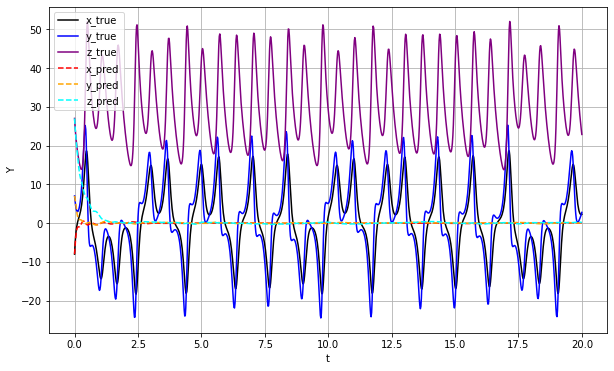

In [101]:
plot_sol(t,[x_true,y_true,z_true],[x_pred,y_pred,z_pred],fname="intermitten.pdf")

In [39]:
def plot_diff(t,Y_true,Y_pred,fname=""):
    x_true,y_true,z_true = Y_true
    x_pred,y_pred,z_pred = Y_pred
    # Plot differences
    plt.figure(figsize=(10,6))
    plt.plot(t, np.abs(x_true-x_pred), color="black", label="x_diff")
    plt.plot(t, np.abs(y_true-y_pred), color="blue", label="y_diff")
    plt.plot(t, np.abs(z_true-z_pred), color="purple", label="z_diff")

    plt.xlabel("t")
    plt.ylabel("diff")
    plt.legend()
    plt.grid()
    if fname:
        plt.savefig(fname,dpi=300,bbox_inches='tight')
    plt.show()

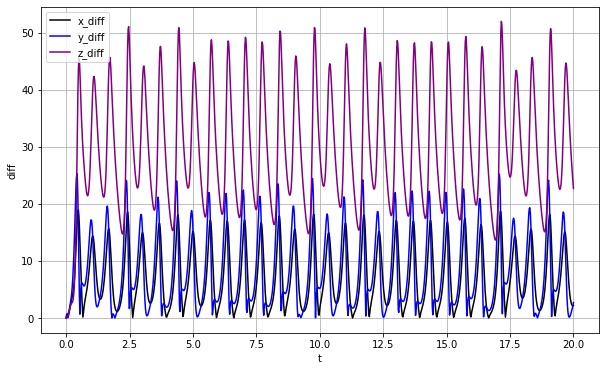

In [102]:
plot_diff(t,[x_true,y_true,z_true],[x_pred,y_pred,z_pred],fname="intermitten-diff.pdf")

In [33]:
def plot_lorenz(x,y,z,fname=""):
    # Plot Lorenz trajectory
    ax = plt.figure(figsize=(10,8)).add_subplot(projection='3d')

    ax.plot(x,y,z, lw=0.5)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    #ax.set_title("Lorenz Attractor")

    if fname:
        plt.savefig(fname,dpi=300,bbox_inches='tight')
    plt.show()

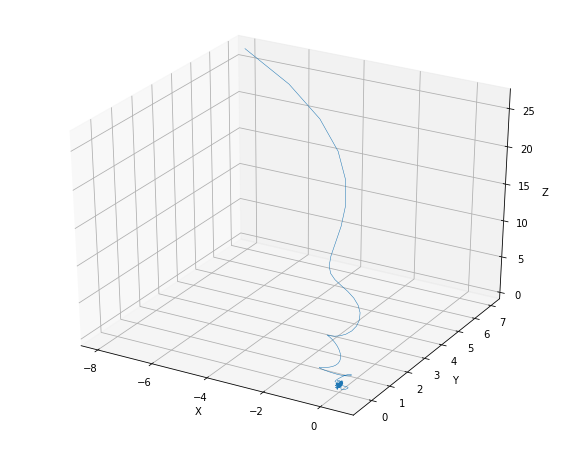

In [103]:
plot_lorenz(x_pred,y_pred,z_pred,fname="intermitten-pred-3d.pdf")

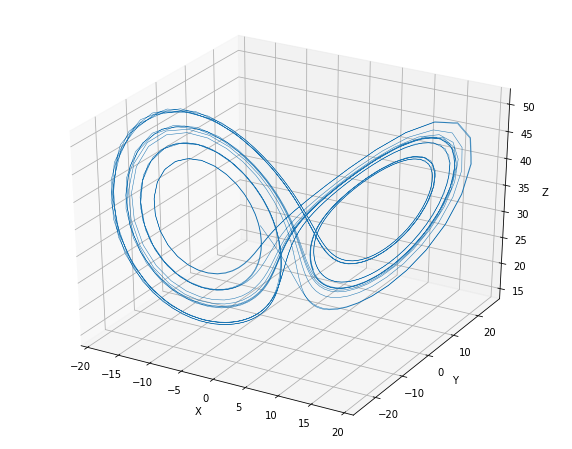

In [104]:
plot_lorenz(x_true,y_true,z_true,fname="intermitten-true-3d.pdf")